# FC 3: Genetic Algorithm in Python

#### Kitzia Ximena Carranza Alvarez 170732

To solve this problem, part of the codes provided in:
  Stoltz, E. (2021, March 18). Evolution of a salesman: A complete genetic algorithm tutorial for Python. Medium. https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

GeeksforGeeks. (2024c, March 8). Genetic algorithms. GeeksforGeeks. https://www.geeksforgeeks.org/genetic-algorithms/

Made the necessary changes and adjustments because the codes were very general and for this practice a more specific task was requested that consisted only of finding the best route from one destination to another and not going through all the destinations to return to the beginning.

In [29]:
# Import the NumPy library to facilitate its use in mathematical operations and array management.
import numpy as np

# Import the 'random' module to generate pseudo-random numbers and perform random operations such as selection or shuffling.
import random

# Import the 'operator' module to use efficient functions like addition or comparison.
import operator

# Import the 'pandas' for manipulation and analysis of structured data.
import pandas as pd

# Import the 'matplotlib.pyplot' for creating static, animated, and interactive graphical visualizations.
import matplotlib.pyplot as plt


## Step 1: Definition of the subway map
Representation of the subway map containing the stations, the connections between them and the travel time.

In [30]:
#This represents a simplified map of a subway system
#where each key is a subway station and each value represents the travel time in minutes required to reach them.
subway_map = {
    'El Rosario': {'Instituto del Petróleo': 6},
    'Cuatro Caminos': {'Tacuba': 2},
    'Tacuba': {'Cuatro Caminos': 2, 'Panteones': 2},
    'Panteones': {'Tacuba': 2, 'Tacubaya': 2},
    'Tacubaya': {'Panteones': 2, 'San Pedro de los Pinos': 2},
    'San Pedro de los Pinos': {'Tacubaya': 2, 'Mixcoac': 2},
    'Mixcoac': {'San Pedro de los Pinos': 2, 'Barranca del Muerto': 2},
    'Barranca del Muerto': {'Mixcoac': 2},
    'Instituto del Petróleo': {'El Rosario': 6, 'Deportivo 18 de Marzo': 2},
    'Deportivo 18 de Marzo': {'Instituto del Petróleo': 2, 'La Raza': 2},
    'La Raza': {'Deportivo 18 de Marzo': 2, 'Consulado': 3, 'Potrero': 2},
    'Potrero': {'La Raza': 2, 'Lindavista': 2},
    'Lindavista': {'Potrero': 2, 'Instituto del Petróleo': 2},
    'Consulado': {'La Raza': 3, 'San Lázaro': 4, 'Morelos': 2},
    'Morelos': {'Consulado': 2, 'Candelaria': 2},
    'Candelaria': {'Morelos': 2, 'San Lázaro': 2},
    'San Lázaro': {'Consulado': 4, 'Candelaria': 2}}

In [31]:
# Iterate over each station and its connections in the subway map
for station, connections in list(subway_map.items()):
    # Iterate over each connected station and the number of segments to it
    for connected_station, segments in list(connections.items()):
        # Check if the connected station is already in the map as a main key
        if connected_station not in subway_map:
            # If not, add it to the map with an empty dictionary for its connections
            subway_map[connected_station] = {}
        # Check if the main station is in the connections of the connected station
        if station not in subway_map[connected_station]:
            # If not, add the main station to the connections of the connected station
            # and assign the number of segments, ensuring bidirectionality
            subway_map[connected_station][station] = segments

## Step 2: Creation of the Chromosome
Each chromosome will be a list of stations that represents a possible path between "El Rosario" and "San Lázaro". The initial generation will be random within the possible connections.

In [32]:
def generate_random_route(start, end, subway_map):
    current_station = start  # Start at the initial station
    route = [start]  # Initialize the route with the starting station
    
    while current_station != end:
        # Get potential next stations that are not already in the route to avoid direct loops
        next_stations = [station for station in subway_map[current_station] if station not in route]
        
        # If no next stations are available (i.e., we've reached a dead end), restart the route generation
        if not next_stations:
            return generate_random_route(start, end, subway_map)
        
        # Randomly select the next station and add it to the route
        next_station = random.choice(next_stations)
        route.append(next_station)
        current_station = next_station  # Move to the next station
    
    return route  # Return the complete route from start to end

In [33]:
# Test generating a random route with the created function
random_route = generate_random_route('El Rosario', 'San Lázaro', subway_map)
random_route

['El Rosario',
 'Instituto del Petróleo',
 'Lindavista',
 'Potrero',
 'La Raza',
 'Consulado',
 'Morelos',
 'Candelaria',
 'San Lázaro']

## Step 3: Fitness Function
The fitness function will evaluate the total length of the route in terms of segments between stations since it seeks to minimize this number.

In [34]:
def calculate_fitness(route, subway_map):
    try:
        # Calculate the total number of segments in the route. The sum iterates over each station in the route
        # (except the last one) and adds up the segments from one station to the next as defined in the subway map.
        total_segments = sum(subway_map[route[i]][route[i + 1]] for i in range(len(route) - 1))
        return 1 / total_segments  # Return the inverse of the total segments to minimize the distance.
                                   # This makes routes with fewer segments have higher fitness values.
    except KeyError:
        # If a KeyError occurs (because the route tries to access a connection between stations that doesn't exist),
        # return a fitness of 0, indicating an invalid route.
        return 0

## Step 4: Selection
Select the chromosomes most suitable for reproduction. A common technique is tournament selection.

In [35]:
def tournament_selection(population, tournament_size, subway_map):
    # Choose a random sample of individuals from the population to participate in the tournament.
    # The size of this sample is determined by the 'tournament_size' parameter.
    tournament = random.sample(population, tournament_size)
    
    # Select the best individual from the tournament sample.
    # The 'max' function is used here with a key function that computes the fitness of each individual using the 'calculate_fitness' function.
    # This ensures that the individual with the highest fitness (lowest total segments in their route) is selected.
    best_individual = max(tournament, key=lambda individual: calculate_fitness(individual, subway_map))
    
    # Return the individual with the highest fitness in the tournament.
    return best_individual

## Step 5: Crossover
The junction operator will combine two routes to produce a new route. Here we will use an ordered safe crossing that preserves the order of stations on major routes to maintain route viability

In [36]:
def safe_ordered_crossover(parent1, parent2, subway_map):
    # Select two random points in the route to define the crossover region. This is done by sampling two indices from the parent route's length.
    start, end = sorted(random.sample(range(len(parent1)), 2))
    
    # Create the child route by combining the segment before the start index from parent1,
    # the segment between start and end index from parent2, and the segment after the end index from parent1.
    child = parent1[:start] + parent2[start:end] + parent1[end:]
    
    # Initialize a list to keep the validated part of the child route starting with the first station of parent1.
    valid_child = [parent1[0]]
    
    # Iterate over each station in the child route starting from the second station.
    for station in child[1:]:
        # Get the last valid station added to the child.
        last_station = valid_child[-1]
        
        # Check if the current station is directly connected to the last valid station in the map.
        # This step ensures that the child route maintains valid consecutive stations as per the subway map.
        if station in subway_map[last_station]:
            # If valid, add this station to the valid_child list.
            valid_child.append(station)
    
    # Check if the length of the valid_child route matches the original child route.
    # If they match, it means the whole route is valid and can be returned.
    # If not, it means some parts of the child route were invalid, and the crossover process is repeated.
    return valid_child if len(valid_child) == len(child) else safe_ordered_crossover(parent1, parent2, subway_map)


## Step 6: Mutation
The mutation will introduce small random changes and also checks the validity of the connections

In [37]:
def safe_mutate(route, mutation_rate, subway_map):
    # Check if a mutation should occur based on a random chance less than the specified mutation rate.
    if random.random() < mutation_rate:
        # Select a random index in the route to swap with the next index, avoiding the first and last stations
        # to prevent creating routes that don't start or end at the designated start/end points.
        idx = random.randint(1, len(route) - 2)  # Avoid the ends of the route

        # Before performing the swap, check if the potential swap would result in a valid connection.
        # after the current index in the subway map. This ensures that the mutation won't create
        # an invalid route.
        if route[idx + 1] in subway_map[route[idx - 1]]:
            # Swap the selected station with the next station if the resulting segment is valid.
            route[idx], route[idx + 1] = route[idx + 1], route[idx]

    # Return the potentially mutated route. If the mutation condition wasn't met or the swap was invalid,
    # the original route is returned unchanged.
    return route

## Step 7: Initialization
Create an initial population of random routes to start the genetic algorithm

In [38]:
def create_initial_population(pop_size, start, end, subway_map):
    # Initialize an empty list to hold the population of routes.
    population = []
    # Loop through the number of individuals needed in the population.
    for _ in range(pop_size):
        # Generate a random route from the start station to the end station using the subway map.
        # Append each generated route to the population list.
        population.append(generate_random_route(start, end, subway_map))
    # Return the complete list of routes which forms the initial population for the genetic algorithm.
    return population

# Define the size of the initial population
population_size = 10  # This is an arbitrary number representing the number of routes in the population.

# Generate the initial population using the function defined above.
# 'El Rosario' is the starting station, 'San Lázaro' is the destination, and 'subway_map' is the map of the metro.
initial_population = create_initial_population(population_size, 'El Rosario', 'San Lázaro', subway_map)

# Display the generated initial population. This line outputs the list of routes.
# Each route is a list of station names, representing a possible path from 'El Rosario' to 'San Lázaro'.
initial_population  

[['El Rosario',
  'Instituto del Petróleo',
  'Lindavista',
  'Potrero',
  'La Raza',
  'Consulado',
  'Morelos',
  'Candelaria',
  'San Lázaro'],
 ['El Rosario',
  'Instituto del Petróleo',
  'Lindavista',
  'Potrero',
  'La Raza',
  'Consulado',
  'San Lázaro'],
 ['El Rosario',
  'Instituto del Petróleo',
  'Deportivo 18 de Marzo',
  'La Raza',
  'Consulado',
  'San Lázaro'],
 ['El Rosario',
  'Instituto del Petróleo',
  'Deportivo 18 de Marzo',
  'La Raza',
  'Consulado',
  'Morelos',
  'Candelaria',
  'San Lázaro'],
 ['El Rosario',
  'Instituto del Petróleo',
  'Deportivo 18 de Marzo',
  'La Raza',
  'Consulado',
  'Morelos',
  'Candelaria',
  'San Lázaro'],
 ['El Rosario',
  'Instituto del Petróleo',
  'Lindavista',
  'Potrero',
  'La Raza',
  'Consulado',
  'San Lázaro'],
 ['El Rosario',
  'Instituto del Petróleo',
  'Deportivo 18 de Marzo',
  'La Raza',
  'Consulado',
  'San Lázaro'],
 ['El Rosario',
  'Instituto del Petróleo',
  'Deportivo 18 de Marzo',
  'La Raza',
  'Consulad

## Step 8: Execution of the Genetic Algorithm
This is the main loop that runs the genetic algorithm for a fixed number of generations.

In [42]:
def genetic_algorithm(subway_map, start_station, end_station, pop_size, generations, mutation_rate):
    # Create an initial population of routes from the start station to the end station using the subway map.
    population = create_initial_population(pop_size, start_station, end_station, subway_map)

    # Iterate through the specified number of generations to evolve the population.
    for generation in range(generations):
        new_population = []  # Prepare a new population for the next generation.
        # Iterate over the current population to generate a new population.
        for _ in range(len(population)):
            # Select two parents from the current population using tournament selection.
            parent1 = tournament_selection(population, 3, subway_map)
            parent2 = tournament_selection(population, 3, subway_map)
            # Generate a child by performing a crossover between the two parents.
            child = safe_ordered_crossover(parent1, parent2, subway_map)
            # Mutate the child at a specified mutation rate.
            child = safe_mutate(child, mutation_rate, subway_map)
            # Add the mutated child to the new population.
            new_population.append(child)
        population = new_population  # Replace the old population with the new population.
        # Calculate and print the best fitness in the current generation to monitor progress.
        best_fitness = max(calculate_fitness(route, subway_map) for route in population)
        print(f"Generation {generation}: Best Fitness = {best_fitness}")

    # After all generations, select the route with the best fitness from the final population.
    best_route = max(population, key=lambda route: calculate_fitness(route, subway_map))
    return best_route

# Set parameters for the genetic algorithm.
pop_size = 10  # The number of routes in the population.
generations = 15  # The number of generations to evolve the population.
mutation_rate = 0.1  # The probability of mutating a route.

# Execute the genetic algorithm to find the best route from 'El Rosario' to 'San Lázaro'.
best_route_found = genetic_algorithm(subway_map, 'El Rosario', 'San Lázaro', pop_size, generations, mutation_rate)

# Print the best route found by the genetic algorithm.
print("Best route from 'El Rosario' to 'San Lázaro':", best_route_found)

Generation 0: Best Fitness = 0.058823529411764705
Generation 1: Best Fitness = 0.058823529411764705
Generation 2: Best Fitness = 0.058823529411764705
Generation 3: Best Fitness = 0.058823529411764705
Generation 4: Best Fitness = 0.058823529411764705
Generation 5: Best Fitness = 0.058823529411764705
Generation 6: Best Fitness = 0.058823529411764705
Generation 7: Best Fitness = 0.058823529411764705
Generation 8: Best Fitness = 0.058823529411764705
Generation 9: Best Fitness = 0.058823529411764705
Generation 10: Best Fitness = 0.058823529411764705
Generation 11: Best Fitness = 0.058823529411764705
Generation 12: Best Fitness = 0.058823529411764705
Generation 13: Best Fitness = 0.058823529411764705
Generation 14: Best Fitness = 0.058823529411764705
Best route from 'El Rosario' to 'San Lázaro': ['El Rosario', 'Instituto del Petróleo', 'Deportivo 18 de Marzo', 'La Raza', 'Consulado', 'San Lázaro']


## Additional step: map the improvement
With a simple adjustment of our genetic algorithm function, we can store the shortest distance of each generation in a progress list and then plot the results.

In [ ]:

#Code of reference:
# def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
   # pop = initialPopulation(popSize, population)
    #progress = []
    #progress.append(1 / rankRoutes(pop)[0][1])
    
    #for i in range(0, generations):
      #  pop = nextGeneration(pop, eliteSize, mutationRate)
      # progress.append(1 / rankRoutes(pop)[0][1])
    
   # plt.plot(progress)
   # plt.ylabel('Distance')
   # plt.xlabel('Generation')
   # plt.show() 


## Modified code for graphics

Generation 0: Best Fitness = 19.0
Generation 1: Best Fitness = 17.0
Generation 2: Best Fitness = 17.0
Generation 3: Best Fitness = 17.0
Generation 4: Best Fitness = 17.0
Generation 5: Best Fitness = 17.0
Generation 6: Best Fitness = 17.0
Generation 7: Best Fitness = 17.0
Generation 8: Best Fitness = 17.0
Generation 9: Best Fitness = 17.0
Generation 10: Best Fitness = 17.0
Generation 11: Best Fitness = 17.0
Generation 12: Best Fitness = 17.0
Generation 13: Best Fitness = 17.0
Generation 14: Best Fitness = 17.0
Generation 15: Best Fitness = 17.0
Generation 16: Best Fitness = 17.0
Generation 17: Best Fitness = 17.0
Generation 18: Best Fitness = 17.0
Generation 19: Best Fitness = 17.0


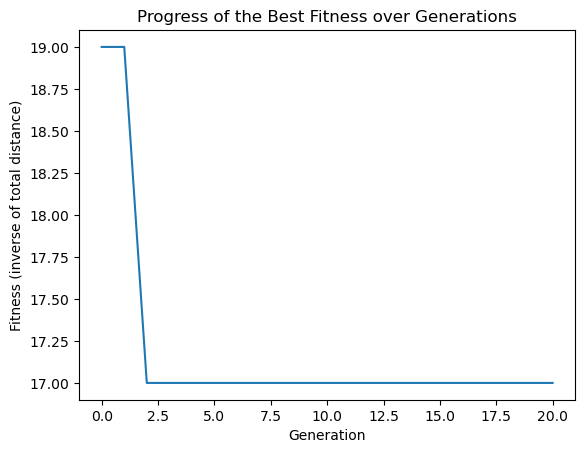

Best route from 'El Rosario' to 'San Lázaro': ['El Rosario', 'Instituto del Petróleo', 'Deportivo 18 de Marzo', 'La Raza', 'Consulado', 'San Lázaro']


In [43]:
import matplotlib.pyplot as plt  # Import the library for plotting

def genetic_algorithm_with_plot(subway_map, start_station, end_station, pop_size, generations, mutation_rate):
    # Create an initial population of routes from the start station to the end station using the subway map
    population = create_initial_population(pop_size, start_station, end_station, subway_map)
    # Initialize a list to track the progress of the best fitness value in each generation
    progress = []
    # Calculate and append the initial best fitness value (inverse of total segments) to the progress list
    best_fitness = min(calculate_fitness(route, subway_map) for route in population)
    progress.append(1 / best_fitness)

    # Loop through the specified number of generations to evolve the population
    for generation in range(generations):
        new_population = []  # Prepare a new population for the next generation
        # Iterate through the current population to generate a new population
        for _ in range(len(population)):
            # Select two parents from the current population using tournament selection
            parent1 = tournament_selection(population, 3, subway_map)
            parent2 = tournament_selection(population, 3, subway_map)
            # Generate a child by performing a crossover between the two parents
            child = safe_ordered_crossover(parent1, parent2, subway_map)
            # Mutate the child at a specified mutation rate
            child = safe_mutate(child, mutation_rate, subway_map)
            # Add the mutated child to the new population
            new_population.append(child)
        population = new_population  # Replace the old population with the new population
        # Calculate the best fitness in the current generation and update the progress list
        best_fitness = min(calculate_fitness(route, subway_map) for route in population)
        progress.append(1 / best_fitness)
        # Print the best fitness of the current generation to monitor progress
        print(f"Generation {generation}: Best Fitness = {1 / best_fitness}")

    # Find and return the route with the best fitness from the final population
    best_route = min(population, key=lambda route: calculate_fitness(route, subway_map))

    # Plot the progress of the best fitness over the generations
    plt.plot(progress)
    plt.ylabel('Fitness (inverse of total distance)')
    plt.xlabel('Generation')
    plt.title('Progress of the Best Fitness over Generations')
    plt.show()

    return best_route

# Parameters for the genetic algorithm
pop_size = 10  # Number of routes in the population
generations = 20  # Number of generations to evolve the population
mutation_rate = 0.1  # Probability of mutating a route

# Run the genetic algorithm and plot the results
best_route_found = genetic_algorithm_with_plot(subway_map, 'El Rosario', 'San Lázaro', pop_size, generations, mutation_rate)
print("Best route from 'El Rosario' to 'San Lázaro':", best_route_found)
